# EarlySign Tutorial: Group Sequential Testing (Two-Proportions) with a Ledger-Centric Design

This tutorial demonstrates how to run a group sequential test (GST) for a two-proportions A/B experiment using a **ledger-centric** architecture.

We will:
1. Initialize a Polars-backed ledger.
2. Iteratively append observation batches (simulated).
3. Update a Wald Z statistic and a Lan–DeMets (OBF/Pocock) boundary per look.
4. Emit a stop signal if the boundary is crossed.
5. Summarize and visualize progress.

## Requirements

```bash
pip install earlysign[examples]
```

In [15]:
import numpy as np

# New business-oriented facade API - all A/B testing functionality in one place
from earlysign.api.ab_test import interim_analysis
from earlysign.runners import SequentialRunner
from earlysign.backends.polars.ledger import PolarsLedger

# Legacy imports (still available for advanced use)
from earlysign.core.names import Namespace, ExperimentId, StepKey, TimeIndex
from earlysign.methods.group_sequential.two_proportions import (
    WaldZStatistic,
    LanDeMetsBoundary,
    PeekSignaler,
    nominal_alpha_increments,
)
from earlysign.reporting.generic import LedgerReporter
from earlysign.reporting.two_proportions import TwoPropGSTReporter

np.set_printoptions(suppress=True)

ImportError: cannot import name 'Observation' from 'earlysign.core.components' (/Users/teshima/2025/EarlySign/earlysign/core/components.py)

## Configure the experiment

We plan 4 looks, a two-sided alpha of 0.05, and O'Brien–Fleming (OBF) spending. We also specify a target fixed-sample size per arm just for this simulation example.


In [ ]:
import math
from datetime import datetime, timezone

# Experiment configuration
exp_id = "exp#loop-demo"
alpha_total = 0.05
looks = 4
spending = "conservative"  # "conservative" (OBF) or "aggressive" (Pocock)

# Step 1: Create a business-oriented experiment using the facade API
# This uses familiar terminology: "interim_analysis" instead of "group_sequential_test"
experiment = interim_analysis(
    experiment_id=exp_id, alpha=alpha_total, looks=looks, spending=spending
)

# Step 2: Create a runner with your chosen backend
# The runner handles execution while the module defines the experiment
runner = SequentialRunner(experiment, PolarsLedger())

print(f"📦 Experiment: {experiment.__class__.__name__}")
print(f"🏃 Runner: {runner.__class__.__name__}")
print(f"⚙️  Backend: {type(runner.ledger).__name__}")

# Simulation parameters (for demonstration)
n_per_arm = 400
t_grid = tuple((i + 1) / looks for i in range(looks))  # (0.25, 0.5, 0.75, 1.0)
targets = [math.ceil(n_per_arm * t) for t in t_grid]

# Ground-truth rates (for simulation)
pA_true, pB_true = 0.70, 0.80
rng = np.random.default_rng(7)

print(f"\n🎯 Experiment Design:")
print(f"   Method: Interim Analysis with {spending} spending")
print(f"   Alpha: {alpha_total}, Looks: {looks}")
print(f"   Targets per look: {targets}")
print(f"   True rates: Group A = {pA_true:.0%}, Group B = {pB_true:.0%}")

# The experiment automatically registers the design when setup() is called by the runner
summary = runner.get_summary()
print(f"\n✅ Setup complete. Components: {summary['components']}")

## Run the sequential procedure in a loop

For each look:
1. Append a new observation batch to the ledger.
2. Update the Wald Z statistic.
3. Update the Lan–DeMets (OBF) boundary at the current information fraction.
4. Let the signaler check whether to **stop early**.

In [ ]:
cum_nA = cum_nB = cum_mA = cum_mB = 0
stopped = False
stop_look = None

for i, t in enumerate(t_grid, start=1):
    # Target sample size up to this look
    target = targets[i - 1]
    add_nA = max(target - cum_nA, 0)
    add_nB = max(target - cum_nB, 0)
    add_mA = int(rng.binomial(add_nA, pA_true)) if add_nA > 0 else 0
    add_mB = int(rng.binomial(add_nB, pB_true)) if add_nB > 0 else 0

    cum_nA += add_nA
    cum_nB += add_nB
    cum_mA += add_mA
    cum_mB += add_mB

    print(f"\n=== Look {i} ===")
    print(f"Adding: Group A {add_mA}/{add_nA}, Group B {add_mB}/{add_nB}")
    print(
        f"Cumulative: Group A {cum_mA}/{cum_nA} ({cum_mA/cum_nA:.1%}), Group B {cum_mB}/{cum_nB} ({cum_mB/cum_nB:.1%})"
    )

    # 1) Add observations using the modular interface
    runner.add_observations(
        group_a_success=add_mA,
        group_a_total=add_nA,
        group_b_success=add_mB,
        group_b_total=add_nB,
    )

    # 2) Run analysis - the module coordinates all components internally
    result = runner.analyze()

    print(f"Z-statistic: {result.statistic_value:.3f}")
    if result.threshold_value:
        print(f"Boundary: ±{result.threshold_value:.3f}")
    print(
        f"Information fraction: {result.additional_metrics.get('information_fraction', 'N/A'):.3f}"
    )
    print(f"Decision: {'🛑 STOP' if result.should_stop else '✅ Continue'}")

    if result.should_stop:
        stopped = True
        stop_look = i
        break

print(f"\n=== Final Result ===")
print(f"Stopped: {stopped}, Stop look: {stop_look}")
print(f"Final sample size: {cum_nA + cum_nB}")

# Get final summary from the runner
final_summary = runner.get_summary()
print(f"Total looks executed: {final_summary['total_looks']}")

# Access the underlying ledger for advanced operations (if needed)
L = runner._ledger

(True, 3)

## Inspect the ledger
We can show a generic view of the ledger and a method-specific progress table.

In [ ]:
from IPython.display import display

gen = LedgerReporter(L.frame())
gen_table = gen.ledger_table()
gen_counts = gen.counts()
display(gen_table)
display(gen_counts)

uuid,time_index,ts,namespace,kind,entity,snapshot_id,tag,payload_type,payload
str,str,"datetime[μs, UTC]",str,str,str,str,str,str,str
"""421a978f-4c79-4443-a91e-19e8bc…","""t_design""",2025-09-07 17:10:32.836200 UTC,"""design""","""registered""","""exp#loop-demo""","""design-v1""","""design""","""TwoPropDesign""","""{""alpha"":0.05,""spending"":""obf""…"
"""70afba7b-0be9-4332-82f5-e7ac7f…","""t1""",2025-09-07 17:10:32.842825 UTC,"""obs""","""observation""","""exp#loop-demo""","""look-1""","""obs""","""TwoPropObsBatch""","""{""nA"":100,""nB"":100,""mA"":64,""mB…"
"""2b014a5f-c690-4f01-b0cb-3c6ea4…","""t1""",2025-09-07 17:10:32.844534 UTC,"""stats""","""updated""","""exp#loop-demo""","""look-1""","""stat:waldz""","""WaldZ""","""{""z"":2.9277002188455983,""se"":0…"
"""e85d8747-9310-4ac8-8469-85f2fd…","""t1""",2025-09-07 17:10:32.845027 UTC,"""criteria""","""updated""","""exp#loop-demo""","""look-1""","""crit:gst""","""GSTBoundary""","""{""upper"":3.919927969080382,""lo…"
"""48d64ea5-b32b-42d0-bdc8-61f509…","""t2""",2025-09-07 17:10:32.846762 UTC,"""obs""","""observation""","""exp#loop-demo""","""look-2""","""obs""","""TwoPropObsBatch""","""{""nA"":100,""nB"":100,""mA"":77,""mB…"
…,…,…,…,…,…,…,…,…,…
"""f7ec9961-d5ea-4048-95e1-e34630…","""t2""",2025-09-07 17:10:32.847411 UTC,"""criteria""","""updated""","""exp#loop-demo""","""look-2""","""crit:gst""","""GSTBoundary""","""{""upper"":2.771807648699362,""lo…"
"""0910318f-4ea5-4868-8c2c-599f21…","""t3""",2025-09-07 17:10:32.848451 UTC,"""obs""","""observation""","""exp#loop-demo""","""look-3""","""obs""","""TwoPropObsBatch""","""{""nA"":100,""nB"":100,""mA"":66,""mB…"
"""c11d3a02-8cae-49f7-88b2-ecbcba…","""t3""",2025-09-07 17:10:32.848914 UTC,"""stats""","""updated""","""exp#loop-demo""","""look-3""","""stat:waldz""","""WaldZ""","""{""z"":3.638293754762681,""se"":0.…"


namespace,kind,count
str,str,u32
"""criteria""","""updated""",3
"""design""","""registered""",1
"""obs""","""observation""",3
"""signals""","""emitted""",1
"""stats""","""updated""",3


In [ ]:
# Tag analysis
print("=== Tag Usage Analysis ===")
import polars as pl

# Get ledger dataframe properly
ledger_df = L._df

# Analyze tag patterns
tag_analysis = (
    ledger_df.select(["namespace", "tag"]).group_by(["namespace", "tag"]).len()
)
print("Namespace + Tag combinations:")
print(tag_analysis)

print("\nUnique tags:")
unique_tags = ledger_df["tag"].unique().sort()
print(unique_tags)

print("\nTag patterns by namespace:")
for ns in ["design", "obs", "stats", "criteria", "signals"]:
    ns_tags = ledger_df.filter(pl.col("namespace") == ns)["tag"].unique().sort()
    print(f"  {ns}: {ns_tags.to_list()}")

=== Tag Usage Analysis ===
Namespace + Tag combinations:
shape: (5, 3)
┌───────────┬──────────────┬─────┐
│ namespace ┆ tag          ┆ len │
│ ---       ┆ ---          ┆ --- │
│ str       ┆ str          ┆ u32 │
╞═══════════╪══════════════╪═════╡
│ signals   ┆ gst:decision ┆ 1   │
│ criteria  ┆ crit:gst     ┆ 3   │
│ stats     ┆ stat:waldz   ┆ 3   │
│ design    ┆ design       ┆ 1   │
│ obs       ┆ obs          ┆ 3   │
└───────────┴──────────────┴─────┘

Unique tags:
shape: (5,)
Series: 'tag' [str]
[
	"crit:gst"
	"design"
	"gst:decision"
	"obs"
	"stat:waldz"
]

Tag patterns by namespace:
  design: ['design']
  obs: ['obs']
  stats: ['stat:waldz']
  criteria: ['crit:gst']
  signals: ['gst:decision']


In [ ]:
rep = TwoPropGSTReporter(L.frame())
progress = rep.progress_table()
progress

time_index,ts,entity,look,z,nA,nB,mA,mB,upper,lower,t,stopped
str,"datetime[μs, UTC]",str,i64,f64,i64,i64,i64,i64,f64,f64,f64,str
"""t1""",2025-09-07 17:10:32.844534 UTC,"""exp#loop-demo""",1,2.9277,100,100,64,82,3.919928,-3.919928,0.25,"""no"""
"""t2""",2025-09-07 17:10:32.847139 UTC,"""exp#loop-demo""",2,2.468454,200,200,141,162,2.771808,-2.771808,0.5,"""no"""
"""t3""",2025-09-07 17:10:32.848914 UTC,"""exp#loop-demo""",3,3.638294,300,300,207,245,2.263171,-2.263171,0.75,"""yes"""


## Visualize Z and boundaries
A simple plot of the Wald Z trajectory and the symmetric boundaries across information fractions.

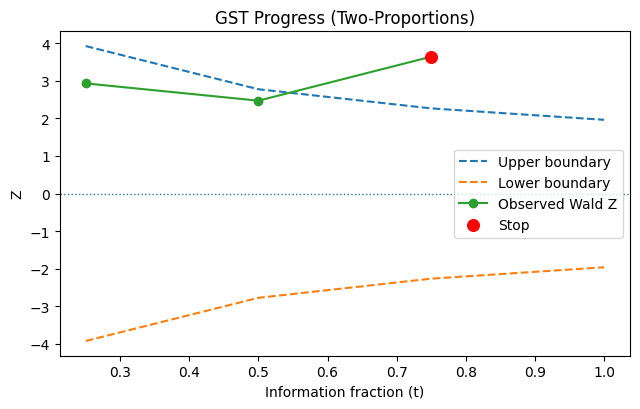

In [ ]:
# If running in a notebook, this will render inline
rep.plot()

## Next steps
- Replace the simulated observation batches with your actual data source.
- Swap OBF with Pocock spending by setting `style="pocock"`.
- Extend the scheme to other data types or add additional criteria/signals.
- Persist the Polars ledger using sinks/sources in `earlysign.backends.polars.io`.

## Advanced: Creating Custom Experiment Modules

The modular architecture makes it easy to create **portable, shareable experiment definitions**. Here's how to create your own custom modules:

### 1. Custom Module Definition
Analysts can create their own modules by subclassing `ExperimentModule` or `TwoPropModule`

### 2. Data Ingestion Components
For complex data scenarios, you can still access the underlying ingestion components

### 3. Module Comparison
Compare different experiment designs using the `BatchRunner`

In [ ]:
from earlysign.schemes.two_proportions.ingest import TwoPropIngestor, ObservationBatch

# Create ingestor with custom validation settings
ingestor = TwoPropIngestor(
    auto_validate=True,
    require_both_groups=True,  # Require data from both groups
    tag_obs="obs:validated",
)

# Example 1: Dictionary format ingestion
data_dict = {
    "group_a_success": 15,
    "group_a_total": 30,
    "group_b_success": 20,
    "group_b_total": 30,
}
batch1 = ingestor.ingest_from_dict(data_dict)
print(f"Dictionary batch rates: {batch1.get_rates()}")

# Example 2: Individual observations (e.g., from real-time stream)
individual_outcomes_a = [True, False, True, True, False, True]
individual_outcomes_b = [True, True, False, True, True, False]
batch2 = ingestor.ingest_from_arrays(individual_outcomes_a, individual_outcomes_b)
print(f"Individual batch payload: {batch2.to_payload()}")

# Example 3: Manual batch building with validation
batch3 = ObservationBatch()
batch3.add_individual_observation("group_a", True)
batch3.add_individual_observation("group_a", False)
batch3.add_individual_observation("group_b", True)

# Check validation
if batch3.validate():
    print("✅ Batch3 is valid")
else:
    print(f"❌ Validation errors: {batch3.validation_errors}")

# Example 4: Integration with existing experiment
# You can still use the experiment's ingestor for advanced operations
print(f"\nExperiment ingestor settings:")
print(f"- Auto validate: {experiment.ingestor.auto_validate}")
print(f"- Require both groups: {experiment.ingestor.require_both_groups}")
print(f"- Tag: {experiment.ingestor.tag_obs}")

# The simplified add_observations() method uses this ingestor internally
print(
    "\n🎯 The experiment.add_observations() method provides the same validation and audit trail!"
)